# Using ML for paramter estimation

In [10]:
%matplotlib inline

In [ ]:
%matplotlib notebook

In [8]:
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model
from scipy.optimize import minimize
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV


"""Loading the Data"""

dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'
UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')
UX1.dropna(subset = ["PX_LAST"], inplace=True)   #Getting rid of NaN values
UX2.dropna(subset = ["PX_LAST"], inplace=True)
UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)
dataset = np.array(UX1.PX_LAST)
# M = 100    #M times magnification
# dataset= dataset * M

In [9]:
"""Specifying the Input & Output (Labels)"""

n=0     #Looking at n previous days, 0 for heston predictor task
X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

In [10]:
"""Splitting Data into Train and Test set"""

m_training= 400
m_test= 100

X_training= X[:m_training]
Y_training= Y[:m_training]   
X_test= X[m_training:m_training+m_test]
Y_test= Y[m_training:m_training+m_test]

if n==0:
    X_training = np.ravel(X_training)
    X_test = np.ravel(X_test)
    Y_training = np.array(Y_training)
    Y_test = np.array(Y_test)

In [4]:
"""Building the Hypothesis"""

def heston_pde_milstein(V0, k, theta, rho, sigma):
    WT  = np.sqrt( 1 ) * np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]
    V1 = np.abs(V0+ k * (theta - V0) * 1 + sigma * np.sqrt(V0) * WT + .25 * sigma**2 * (WT**2 - 1))
    return V1

In [5]:
"""Building the Loss Function"""

#The difference between real label and the predicted one to the power of 2
#l = (heston_pde_milstein(X_training[i], r, k, theta, rho, sigma) - Y_training[i])**2

m=len(X_training)  #Training set size
# k: x[0], theta:x[1], rho:x[2], sigma:x[3]

def Ls(X):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[2]], [X[2], 1]]))[1]
        V1 =  np.abs(X_training[i] + X[0] * (X[1] - X_training[i]) * 1 + 
                     X[3] * np.sqrt(X_training[i]) * WT + .25 * X[3]**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training[i])**2 for i in range(m)]))
    return Ls

In [6]:
"""TEST"""

m=len(X_training)  #Training set size
def Ls(X):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, -0.7], [-0.7, 1]]))[1]
        V1 =  np.abs(X_training[i] + x[0] * (0 - X_training[i]) * 1 + 
                     X[1] * np.sqrt(X_training[i]) * WT + .25 * X[1]**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training[i])**2 for i in range(m)]))
    return Ls

In [27]:
pip install numdifftools

  Created wheel for algopy: filename=algopy-0.5.7-py3-none-any.whl size=107616 sha256=f9f32b691b5f7e7ebba697d2f2c207060c70122ecadaa13f42e22cb23e27d090
  Stored in directory: c:\users\enkidu\appdata\local\pip\cache\wheels\0d\18\4f\be14421713ec96521183a9f4dc86becb3e6c1bf1b5578a4e57
Successfully built algopy
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numdifftools as nd
print(nd.__version__)

0.9.40


In [5]:

def rosen(x): 
    return (1-x[0])**2 +(x[1]-x[0]**2)**2 + 5* x[2]
  
grad2 = nd.Gradient(rosen)([1, 2, 5])
print("Gradient of (1-x ^ 2)+(y-x ^ 2)^2 at (1, 2) is ", grad2)

Gradient of x ^ 4 + x+1 at x = 1 is  5.0
Gradient of (1-x ^ 2)+(y-x ^ 2)^2 at (1, 2) is  [-4.  2.  5.]


In [31]:
"""Re_investigating the Loss Function"""


def grad(params):
    
    m=len(X_training)  #Training set size
    def Ls(X):
        def heston_inner_func(i):   #calculates the predicted lable for each training sample
            WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
            V1 =  np.abs(X_training[i] + X[1] * (X[2] - X_training[i]) * 1 + 
                         X[3] * np.sqrt(X_training[i]) * WT + .25 * X[3]**2 * (WT**2 - 1))
            return V1
        Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training[i])**2 for i in range(m)]))
        return Ls
    
    G = nd.Gradient(Ls)([params[0], params[1], params[2], params[3]])
    return G

def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,4])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

Nsteps=1
lr_l=1

init1 = np.array([-0.7,0.5,0,1.5])
adam_trajectory1=adams(grad,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)
minimum = adam_trajectory1[-1]
print(minimum)

<ipython-input-31-2d55de6fd0c4>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]


[-1.7 -0.5 -1.   0.5]


In [28]:
init1 = np.array([0,0.5,0.6,-0.5])
adam_trajectory1=adams(grad,init1,Nsteps,eta=lr_l, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0)
minimum = adam_trajectory1[-1]
print(minimum)

<ipython-input-26-44afd5388870>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
<ipython-input-26-44afd5388870>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
<ipython-input-26-44afd5388870>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
<ipython-input-26-44afd5388870>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
<ipython-input-26-44afd5388870>:9: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, X[0]], [X[0], 1]]))[1]
<ipython-input-26-44afd5388870>:9: RuntimeWarning: covariance is not positi

[ 1.66237705  0.26748161 -0.36082657  0.6086186 ]


In [132]:
"""ERM: Empirical Risk Minimization"""

# result1 = minimize(Ls, (3,3,3))  #initial values should be given
# result2 = minimize(Ls, (0, 0, 0))

result = minimize(Ls, (0.1, 1.5))

In [122]:
# best_params1 = result1.x
# best_params2 = result2.x
best         = result.x
print(result.fun)
# print("Best Paramteres_2",  best_params1)
# print("Best Paramteres_1:", best_params2)
print("best", best)

# print("Minimum Ls_1:", result1.fun)
# print("Minimum Ls_2:", result2.`fun)

54201.39678624259
best [0.10000457 1.49999996]


In [192]:
def Ls(X,Y, theta, rho):
    def heston_inner_func(i):   #calculates the predicted lable for each training sample
        WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]
        V1 =  np.abs(X_training[i] + X * (theta - X_training[i]) * 1 + 
                     Y * np.sqrt(X_training[i]) * WT + .25 * Y**2 * (WT**2 - 1))
        return V1
    Ls = (1/m) * np.sum(np.array([(heston_inner_func(i) - Y_training[i])**2 for i in range(m)]))
    return Ls

Z,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11 = [],[],[],[],[],[],[],[],[],[],[],[]
for x in np.linspace(-3,3,6):
    for y in np.linspace(-3,3,12):
        Z.append(Ls(x,y,0,-40))
        Z1.append(Ls(x,y,0.6, 0))
        Z2.append(Ls(x,y,1, +40))
        
#         Z3.append(Ls(x,y,0,-0.5))
#         Z4.append(Ls(x,y,0,0))
#         Z5.append(Ls(x,y,0,0.2))
        
#         Z6.append(Ls(x,y,0,0.6))
#         Z7.append(Ls(x,y,0.2,1))
#         Z8.append(Ls(x,y,0, 1.9))
        
#         Z9.append(Ls(x,y,0,3))
#         Z10.append(Ls(x,y,0,5))
#         Z11.append(Ls(x,y,0,10))  

<ipython-input-192-e483622eccca>:3: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]


### PLOTS COLLECTION

<Figure size 432x288 with 0 Axes>

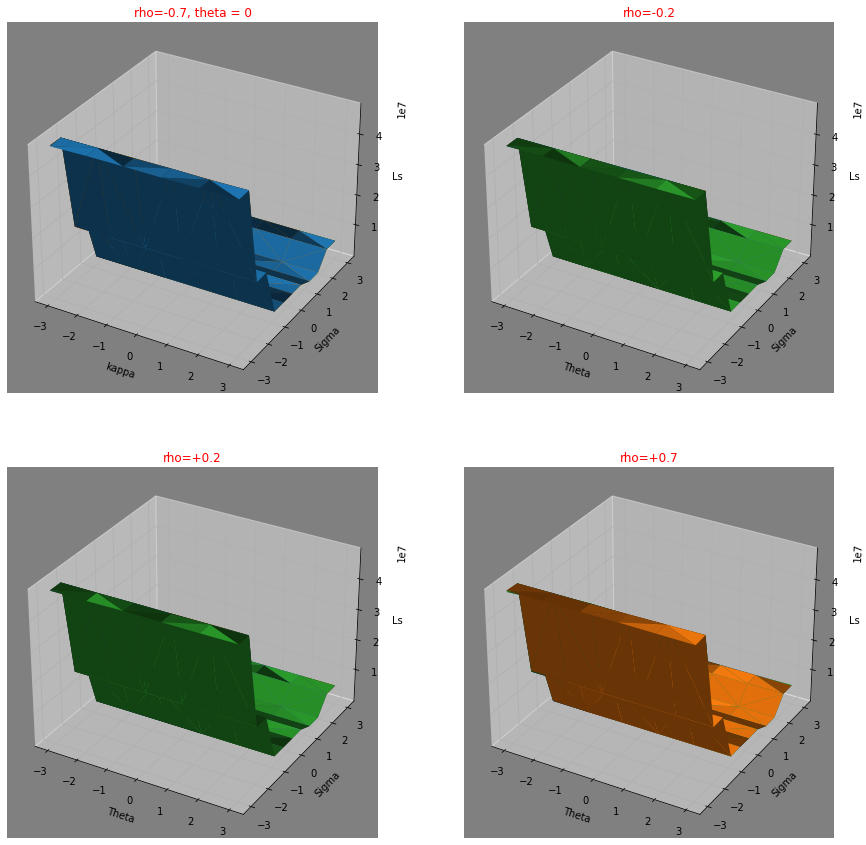

<Figure size 432x288 with 0 Axes>

In [189]:
%matplotlib inline

##################################################################

x = np.linspace(-3,3,6)
y = np.linspace(-3,3,12)
X,Y = np.meshgrid(x,y)
X =  np.ravel(X)
Y =  np.ravel(Y)

# fig, ax1 = plt.subplots( subplot_kw={"projection": "3d"}, figsize=(10,10))
fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(15,15))
ax1.plot_trisurf(X,Y,Z)
ax1.plot_trisurf(X,Y,Z1, label = "-0.5")
ax1.plot_trisurf(X,Y,Z2, label = "0")
ax1.set_title('rho=-0.7, theta = 0', color ='red')
ax1.set_xlabel('kappa')
ax1.set_ylabel('Sigma')
ax1.set_zlabel('Ls')
# ax.legend(loc="best")
ax1.set_facecolor("gray")

ax2.plot_trisurf(X,Y,Z3, label = "0.5")
ax2.plot_trisurf(X,Y,Z4, label = "-0.5")
ax2.plot_trisurf(X,Y,Z5, label = "0")
ax2.set_title('rho=-0.2', color ='red')
ax2.set_xlabel('Theta')
ax2.set_ylabel('Sigma')
ax2.set_zlabel('Ls')
# ax.legend(loc="best")
ax2.set_facecolor("gray")

ax3.plot_trisurf(X,Y,Z6, label = "0.5")
ax3.plot_trisurf(X,Y,Z7, label = "-0.5")
ax3.plot_trisurf(X,Y,Z8, label = "0")
ax3.set_title('rho=+0.2', color ='red')
ax3.set_xlabel('Theta')
ax3.set_ylabel('Sigma')
ax3.set_zlabel('Ls')
# ax.legend(loc="best")
ax3.set_facecolor("gray")

ax4.plot_trisurf(X,Y,Z9, label = "0.5")
ax4.plot_trisurf(X,Y,Z10, label = "-0.5")
ax4.plot_trisurf(X,Y,Z11, label = "0")
ax4.set_title('rho=+0.7', color ='red')
ax4.set_xlabel('Theta')
ax4.set_ylabel('Sigma')
ax4.set_zlabel('Ls')
# ax.legend(loc="best")
ax4.set_facecolor("gray")

plt.figure()

In [7]:
"""Interactive Mode: rho=-0.7 and theta = 0"""
#paramteres: kapa and sigma

%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

###################################################################

x = np.linspace(-3,3,6)
y = np.linspace(-3,3,12)
X,Y = np.meshgrid(x,y)
X =  np.ravel(X)
Y =  np.ravel(Y)

fig, ax0 = plt.subplots( subplot_kw={"projection": "3d"}, figsize=(10,10))
# fig, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2, subplot_kw={"projection": "3d"}, figsize=(15,15))
ax0.plot_trisurf(X,Y,Z)
ax0.plot_trisurf(X,Y,Z1, label = "-0.5")
ax0.plot_trisurf(X,Y,Z2, label = "0")
ax0.set_title('rho=-0.7, theta = 0', color ='red')
ax0.set_xlabel('kappa')
ax0.set_ylabel('Sigma')
ax0.set_zlabel('Ls')
# ax.legend(loc="best")
ax0.set_facecolor("gray")

<IPython.core.display.Javascript object>

NameError: name 'Z' is not defined

In [14]:
"""Evaluating the model on test Set"""

k, theta, rho, sigma = best_params[0], best_params[1], best_params[2], best_params[3]
Y_pred = np.array([heston_pde_milstein(X_test[i], k, theta, rho, sigma) for i in range(len(X_test))])
Y_pred = np.ravel(Y_pred)

#True Error
Ld =  (1/len(Y_test)) * np.sum((Y_pred - Y_test)**2)
print(Ld)

360.3667427139515


<ipython-input-13-7abb1314c351>:4: RuntimeWarning: covariance is not positive-semidefinite.
  WT  = np.sqrt( 1 ) * np.random.multivariate_normal(np.array([0, 0]), np.array([[1, rho], [rho, 1]]))[1]


In [ ]:
Y_pred_train = np.array([heston_pde_milstein(X_training[i], k, theta, rho, sigma) for i in range(len(X_training))])
L =  (1/m) * np.sum((Y_pred_train - Y_training)**2)
print(L)

print(Y_pred_train[:50])
print(Y_training[:50])

## Using Neural Network for the Whole task: A Non-Physical Experiment

In [11]:
#Let's, just for a momemnt, Ignore any pre_knowledge about the subject and see what happens
#Don't forget to run the first cell, just the first one 

n=0     #Looking at n previous days to estimate paramteres + today's volatility
X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

# Putting more emphasis on today's data:f

emphasis = 1    #repearing today's value emphasis times
for i in range(len(X)):
    for j in range(emphasis-1):
        X[i].append(X[i][-1])        

m_training= 2000
m_test= 1000

X_training=X[:m_training]
Y_training=Y[:m_training]   
X_test=X[m_training:m_training+m_test]
Y_test=Y[m_training:m_training+m_test]
    
    
#Let's scale the Volatilities:
M = 100    #M times magnification

X_training= np.array(X_training) * M
Y_training= np.array(Y_training) * M
X_test= np.array(X_test) * M
Y_test= np.array(Y_test) * M

In [ ]:
NN_R = MLPRegressor(hidden_layer_sizes=(20, 20, 20), max_iter=1000, 
                    alpha=1e-4, solver='adam', momentum=0.9,
                    activation='relu', tol=1e-4, learning_rate_init=0.01)
NN_R.fit(X_training, Y_training)
Y_pred = NN_R.predict(X_test)
# print("Predicted Volatilty:\n", Y_pred[100:120])
# print("\nTrue Volatility:\n",     Y_test[100:120])
print("\nThe score:", NN_R.score(X_test, Y_test))

In [ ]:
# Model Selection, Grid Search CV
NN_R = MLPRegressor(max_iter=1000, alpha=1e-4, solver='adam', momentum=0.9,
                    activation='relu', tol=1e-4, learning_rate_init=0.001)
parameters = {'hidden_layer_sizes': [(20),(20,20),(20,20,20),(20,20,20,20),(20,20,20,20,20)]}

gsc = GridSearchCV(NN_R, parameters, cv=5)

gsc.fit(X_training, Y_training)

print("Best parameters set found:")
print(gsc.best_params_)
print("\n")

print("Score with best parameters:")
print(gsc.best_score_)
print("\n")

print("All scores on the grid:")
print(gsc.cv_results_.get('split0_test_score'))
print(gsc.cv_results_.get('split1_test_score'))
print(gsc.cv_results_.get('split2_test_score'))
print(gsc.cv_results_.get('split3_test_score'))
print(gsc.cv_results_.get('split4_test_score'))
print(gsc.cv_results_.get('split5_test_score'))

In [ ]:
#at this point we don't know if we are getting a good score just beacuse of the similarity between volatlities or
#the model is working properly, we should try to figure out a way to find this!
#let's plot the graphs and see what's going on
plt.style.use('dark_background')
plt.figure(figsize=(13,6))
plt.scatter([t for t in range(len(Y_test))], Y_test, alpha= 0.6,color='gold', marker='.', label='Y_test')
plt.scatter([t for t in range(len(Y_test))], Y_pred, alpha= 0.6,color='b', marker='.', label='Y_pred')
plt.scatter([t for t in range(len(Y_test))], 
            [X_test[i][-1] for i in range(len(Y_test))],alpha= 0.6, color='r', marker='.', label='X_test')
# plt.xlim(550,600)
# plt.ylim(3000,5000)
plt.legend()

In [ ]:
#It seems that the result is merely a translation of today's volalitilies not the predictions for tomorrow!
#but let's measure this preciesly

# Distance_from_tomorrow    = np.sum(np.abs(Y_pred - Y_test))
# Distance_from_today = np.sum(np.abs(
#             np.array(Y_pred - [X_test[i][-1] for i in range(len(list(Y_test)))])))

# plt.figure(figsize=(13,6))
# plt.scatter([t for t in range(len(Y_pred))], Distance_from_today, marker = '+', label = 'Distance to Today')
# plt.scatter([t for t in range(len(Y_pred))], Distance_from_tomorrow, marker = '+', label = 'Distance to Tomorrow')
# # plt.xlim(100,140)
# # plt.ylim(-0.5,1)

# plt.legend()

# print("Distance to Today:\n", np.sum(Distance_from_today))
# print("\nDistance to Tommorow:\n", np.sum(Distance_from_tomorrow))

In [ ]:
#Let's Investigate the behaviour of Distance w.r to n and emphasis(Looking at n previous data)
#Just Run the fist Cell before running this cell

D_today = []  #The list to save all values
D_tomorrow = []

for emphasis in [3]:
    Distance_from_today_list    = []
    Distance_from_tomorrow_list = []
    
    for n in range(0,100,5):
        X= [[dataset[j] for j in range(i, i+n+1)] for i in range(len(dataset) - n - 1)]
        Y= [dataset[i+n+1] for i in range(len(dataset) - n -1)]

        for i in range(len(X)):
            for j in range(emphasis-1):
                X[i].append(X[i][-1])    
                
        m_training = 2000
        m_test     = 1000
        X_training=X[:m_training]
        Y_training=Y[:m_training]   
        X_test=X[m_training:m_training+m_test]
        Y_test=Y[m_training:m_training+m_test]
                 
        M = 10    #M times magnification
        X_training= np.array(X_training) * M
        Y_training= np.array(Y_training) * M
        X_test= np.array(X_test) * M
        Y_test= np.array(Y_test) * M

        NN_R.fit(X_training, Y_training)
        Y_pred = NN_R.predict(X_test)
    
        Distance_from_tomorrow    = np.sum(np.abs(Y_pred - Y_test))
        Distance_from_today = np.sum(np.abs(
            np.array(Y_pred - [X_test[i][-1] for i in range(len(list(Y_test)))])))
        Distance_from_today_list.append(Distance_from_today)
        Distance_from_tomorrow_list.append(Distance_from_tomorrow)

    D_today.append(Distance_from_today_list)
    D_tomorrow.append(Distance_from_tomorrow_list)
    
    #Normalization:
    D_today= np.array(D_today)/(max(np.array(D_today).max(),np.array(D_tomorrow).max()))
    D_tomorrow= np.array(D_tomorrow)/(max(np.array(D_today).max(), np.array(D_tomorrow).max()))
    
    # Plotting the Result of previous part
plt.figure(figsize=(13,7))
# plt.plot([t for t in range(L)], Distance_from_today_list, )
plt.plot([t for t in range(len(D_tomorrow[0]))], D_tomorrow[0],
            marker="o", label = 'tom')
plt.plot([t for t in range(len(D_today[0]))],    D_today[0],
            marker="o", label = 'tod')
# plt.scatter([t for t in range(len(D_tomorrow[0]))], D_tomorrow[1],
#             marker="+",color='b', label = 'Emphasis =3')
# plt.scatter([t for t in range(len(D_tomorrow[0]))], D_tomorrow[2],
#             marker="+",color='r', label = 'Emphasis =5')
# plt.scatter([t for t in range(len(D_tomorrow[0]))], D_tomorrow[3],
#             marker="+",color='0', label = 'Emphasis =10')
plt.xlabel('n')
plt.ylabel('Distance')
plt.legend()
plt.show()

## Comparison of Ml method to MLE method:

-0.7600333827408636
